In [1]:
from pathlib import Path
import sys, os

cwd = Path().resolve()
project_root = cwd.parent
sys.path.insert(0, str(project_root))


import numpy as np
import torch
import torchvision
import torchvision.transforms.v2 as transforms
from torch.utils.data import DataLoader
from tqdm import tqdm
import torch.nn as nn
import torch.optim as optim

from pytagi import HRCSoftmaxMetric, Utils, exponential_scheduler
from examples.tagi_resnet_model import resnet18_cifar10



import pytagi
from pytagi.nn import (
    AvgPool2d,
    BatchNorm2d,
    Conv2d,
    Linear,
    MixtureReLU,
    OutputUpdater,
    ReLU,
    Remax,
    Sequential,
)

CNN_NET = Sequential(
    Conv2d(3, 32, 5, bias=False, padding=2, in_width=32, in_height=32),
    ReLU(),
    BatchNorm2d(32),
    AvgPool2d(3, 2, padding=1, padding_type=2),
    ReLU(),
    BatchNorm2d(32),
    AvgPool2d(3, 2, padding=1, padding_type=2),
    Conv2d(32, 64, 5, bias=False, padding=2),
    ReLU(),
    BatchNorm2d(64),
    AvgPool2d(3, 2, padding=1, padding_type=2),
    Linear(64 * 4 * 4, 256),
    ReLU(),
    Linear(256, 10),
    Remax(),
)




In [2]:
torch.manual_seed(17)

# Constants for dataset normalization
NORMALIZATION_MEAN = [0.4914, 0.4822, 0.4465]
NORMALIZATION_STD = [0.2470, 0.2435, 0.2616]

def one_hot_encode(labels, num_classes=10):
    """Convert labels to one-hot encoding"""
    labels = labels.clone().detach()
    return F.one_hot(labels, num_classes=num_classes).numpy().flatten()


def custom_collate_fn(batch):
    # batch is a list of tuples (image, label)
    batch_images, batch_labels = zip(*batch)

    # Convert to a single tensor
    batch_images = torch.stack(batch_images)
    batch_labels = torch.tensor(batch_labels)

    # Flatten images to shape (B*C*H*W,)
    batch_images = batch_images.reshape(-1)

    # Convert to numpy arrays
    batch_images = batch_images.numpy()

    return batch_images, batch_labels


def load_datasets(batch_size: int):
    """Load and transform CIFAR10 training and test datasets."""
    transform_train = transforms.Compose(
        [
            transforms.RandomCrop(32, padding=4),
            transforms.RandomHorizontalFlip(p=0.5),
            transforms.ToImage(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize(
                mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD
            ),
        ]
    )

    transform_test = transforms.Compose(
        [
            transforms.ToImage(),
            transforms.ConvertImageDtype(torch.float32),
            transforms.Normalize(
                mean=NORMALIZATION_MEAN, std=NORMALIZATION_STD
            ),
        ]
    )

    train_set = torchvision.datasets.CIFAR10(
        root="../data/cifar",
        train=True,
        download=True,
        transform=transform_train,
    )
    test_set = torchvision.datasets.CIFAR10(
        root="../data/cifar",
        train=False,
        download=True,
        transform=transform_test,
    )

    train_loader = DataLoader(
        train_set,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True,
        num_workers=1,
        collate_fn=custom_collate_fn,
    )
    test_loader = DataLoader(
        test_set,
        batch_size=batch_size,
        shuffle=False,
        num_workers=1,
        drop_last=True,
        collate_fn=custom_collate_fn,
    )
    return train_loader, test_loader


In [ ]:
images = {}
m_preds = {}
v_preds = {}



def tagi_trainer(
    num_epochs: int,
    batch_size: int,
    device: str,
    sigma_v: float,
):
    """
    Run classification training on the Cifar dataset using a custom neural model.

    Parameters:
    - num_epochs: int, number of epochs for training
    - batch_size: int, size of the batch for training
    """
    utils = Utils()
    train_loader, test_loader = load_datasets(batch_size)


    nb_classes = 10

    # Resnet18

    net = resnet18_cifar10(gain_w=1.0, gain_b=1.0, is_remax=True)

    net.to_device("cuda" if pytagi.cuda.is_available() else "cpu")

    net.load("../models_bin/cifar10_resnet_remax_epoch_40.bin")

    # Testing
    net.eval()
    test_error = 0
    num_test_samples = 0
    count = 0

    for data, target in test_loader:
        m_pred, v_pred = net(data)

        for i in range(len(target)):
            images[count] = data[i * 1024 * 3 : (i + 1) * 1024 * 3]
            m_preds[count] = m_pred[i * 10 : (i + 1) * 10]
            v_preds[count] = v_pred[i * 10 : (i + 1) * 10]
            count += 1

        # Calculate test error
        pred = np.reshape(m_pred, (batch_size, 10))
        label = np.argmax(pred, axis=1)
        test_error += np.sum(label != target.numpy())
        num_test_samples += len(target)

    test_error_rate = (test_error / num_test_samples) * 100
    print(
        f"Test Error: {test_error_rate:.2f}%"
    )


In [4]:
framework = "tagi"
batch_size = 128
epochs = 0
device = "cuda"
sigma_v = 0.1


tagi_trainer(
    batch_size=batch_size, num_epochs=epochs, device=device, sigma_v=sigma_v
)

Files already downloaded and verified
Files already downloaded and verified
Test Error: 14.00%


m_preds: [1.2449877e-05 9.6330510e-08 9.6330510e-08 9.6330510e-08 9.6330510e-08
 9.6330510e-08 9.6330510e-08 9.6330510e-08 9.9998671e-01 9.6330510e-08]
v_preds: [2.2247793e-06 7.9752782e-09 7.9752782e-09 7.9752782e-09 7.9752782e-09
 7.9752782e-09 7.9752782e-09 7.9752782e-09 6.6755429e-06 7.9752782e-09]


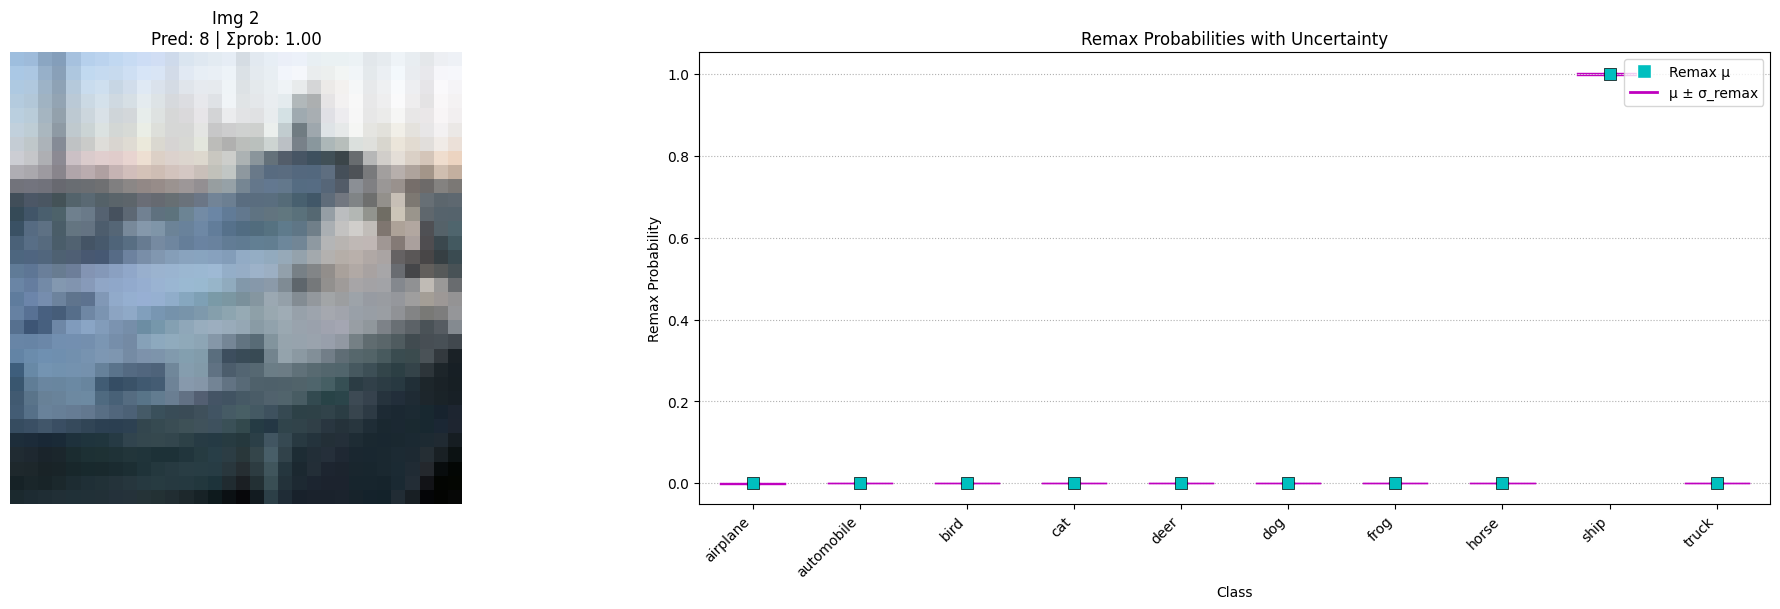

In [5]:
import matplotlib.pyplot as plt
from matplotlib.lines import Line2D

def plot_class_uncertainty(image_idx, images, m_preds, v_preds, delta=0.3):
    """
    Plots CIFAR-10 images with class probabilities, uncertainties, and Remax probabilities.
    """
    # 1. Fix image preprocessing for CIFAR-10
    img = images[image_idx]
    img = img.reshape(3, 32, 32).transpose(1, 2, 0)

    class_names = ['airplane', 'automobile', 'bird', 'cat', 'deer',
                   'dog', 'frog', 'horse', 'ship', 'truck']

    # Denormalize if using standard CIFAR normalization
    mean = np.array([0.4914, 0.4822, 0.4465])
    std = np.array([0.2470, 0.2435, 0.2616])
    img = std * img + mean  # Reverse normalization
    img = np.clip(img, 0, 1)  # Ensure valid pixel range

    # 2. Handle probabilistic outputs
    means = m_preds[image_idx]

    classes = np.arange(10)

    # 3. Compute Remax values
    mA, s2A = means, v_preds[image_idx]
    sA = np.sqrt(s2A)

    # 4. Create figure with three subplots
    fig, (ax_img, ax_remax) = plt.subplots(1, 2, figsize=(21, 6))

    # Image plot (CIFAR-10 specific)
    ax_img.imshow(img)
    ax_img.set_title(f'Img {image_idx}\nPred: {np.argmax(means)} | Σprob: {np.sum(means):.2f}')
    ax_img.axis('off')


    # Remax probability plot
    for i in classes:
        # Remax uncertainty (magenta)
        ax_remax.errorbar(i, mA[i], yerr=sA[i], fmt='none', ecolor='m',
                         elinewidth=1, capsize=5)
        ax_remax.plot([i-0.3, i+0.3], [mA[i]+sA[i], mA[i]+sA[i]], 'm', linewidth=1)
        ax_remax.plot([i-0.3, i+0.3], [mA[i]-sA[i], mA[i]-sA[i]], 'm', linewidth=1)
        ax_remax.scatter(i, mA[i], color='c', marker='s', s=80,
                        zorder=3, edgecolor='k', linewidth=0.5)

    # Remax plot formatting
    ax_remax.set_xticks(classes)
    ax_remax.set_xticklabels(class_names, rotation=45, ha='right', fontsize=10)
    ax_remax.set_xlim(-0.5, 9.5)
    ax_remax.grid(True, axis='y', linestyle=':')
    ax_remax.set_xlabel('Class')
    ax_remax.set_ylabel('Remax Probability')
    ax_remax.set_title('Remax Probabilities with Uncertainty')

    # Remax plot legend
    remax_legend = [
        Line2D([0], [0], marker='s', color='w', label='Remax μ',
              markerfacecolor='c', markersize=10),
        Line2D([0], [0], color='m', lw=2, label='μ ± σ_remax')
    ]
    ax_remax.legend(handles=remax_legend, loc='upper right')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.15)
    plt.show()



print("m_preds:", m_preds[2])
print("v_preds:", v_preds[2])

plot_class_uncertainty(2, images, m_preds, v_preds)

## Calibration

In [6]:
import numpy as np

# Convert dict of softmax outputs into a (N, 10) array
probs = np.array([m_preds[i] for i in range(len(m_preds))])  # shape: (N, 10)

true_labels = []
train_loader, test_loader = load_datasets(batch_size)
for _, targets in test_loader:
    true_labels.extend(targets.numpy())
true_labels = np.array(true_labels)  # shape: (N,)

Files already downloaded and verified
Files already downloaded and verified


The **Expected Calibration Error (ECE)** is a metric used to quantify the calibration of probabilistic models. It's calculated by partitioning predictions into $M$ bins based on their confidence, then summing the absolute difference between the accuracy and average confidence within each bin, weighted by the proportion of samples in that bin.

The formula for ECE is:

$$ ECE = \sum_{m=1}^{M} \frac{|B_m|}{N} |acc(B_m) - conf(B_m)| $$

Where:
- $M$ is the number of bins.
- $B_m$ is the set of samples whose prediction confidence falls into bin $m$.
- $|B_m|$ is the number of samples in bin $m$.
- $N$ is the total number of samples.
- $acc(B_m)$ is the accuracy of predictions in bin $m$.
- $conf(B_m)$ is the average confidence of predictions in bin $m$.

In [7]:
def compute_ece(probs, labels, n_bins=10):
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0
    for i in range(n_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)

        if prop_in_bin > 0:
            acc_in_bin = np.mean(predictions[in_bin] == labels[in_bin])
            avg_conf_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(avg_conf_in_bin - acc_in_bin) * prop_in_bin

    return ece

The **Reliability Diagram** visualizes a model's **calibration** by comparing its predicted **confidence** to its **actual accuracy**.

* **X-axis (Confidence)**: Divided into bins based on prediction confidence.
* **Y-axis (Accuracy)**: Represents the true accuracy.
* **Blue Bars (Actual Accuracy)**: Show the proportion of correct predictions within each confidence bin.
* **Red Line (Average Confidence)**: This line represents the **average confidence level of all predictions that fall into a particular bin**. For instance, if you consider the bin for confidences between 0.7 and 0.8, the red line at the center of that bin will show the *average* confidence of all the predictions that the model made within that 0.7-0.8 range. It essentially tells you "On average, how confident was the model for the predictions in this bin?"
* **Gray Dashed Line (Perfect Calibration)**: The ideal line where confidence perfectly matches accuracy.
* **Numbers Above Bars (Bin Counts)**: Indicate the number of samples in each bin.

A **well-calibrated model** will have its blue bars and red line closely aligned with the gray dashed line. Deviations show over- or under-confidence.

In [8]:
import numpy as np
import matplotlib.pyplot as plt

def plot_reliability_diagram(probs, labels, n_bins=10):
    """
    Plot a detailed reliability diagram with confidence line, bin counts, and accuracy bars.

    Parameters:
    - probs: ndarray of shape (N, num_classes)
    - labels: ndarray of shape (N,)
    - n_bins: int, number of confidence bins
    """
    confidences = np.max(probs, axis=1)
    predictions = np.argmax(probs, axis=1)
    correct = predictions == labels

    bin_edges = np.linspace(0.0, 1.0, n_bins + 1)
    bin_centers = (bin_edges[:-1] + bin_edges[1:]) / 2
    bin_accs = np.zeros(n_bins)
    bin_confs = np.zeros(n_bins)
    bin_counts = np.zeros(n_bins)

    for i in range(n_bins):
        in_bin = (confidences > bin_edges[i]) & (confidences <= bin_edges[i + 1])
        bin_counts[i] = np.sum(in_bin)
        if bin_counts[i] > 0:
            bin_accs[i] = np.mean(correct[in_bin])
            bin_confs[i] = np.mean(confidences[in_bin])

    # Plotting
    fig, ax = plt.subplots(figsize=(6, 6))

    # Bar: accuracy per bin
    ax.bar(bin_centers, bin_accs, width=1/n_bins, color='cornflowerblue', edgecolor='black', alpha=0.9, label='Actual Accuracy')

    # Red line: confidence per bin
    ax.plot(bin_centers, bin_confs, 'o-', color='red', label='Avg Confidence', linewidth=2)

    # Dashed line: perfect calibration
    ax.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Calibration')

    # Count labels
    for i in range(n_bins):
        if bin_counts[i] > 0:
            ax.text(bin_centers[i], bin_accs[i] + 0.02, f'{int(bin_counts[i])}', ha='center', fontsize=9)

    ax.set_xlabel('Confidence')
    ax.set_ylabel('Accuracy')
    ax.set_title('Reliability Diagram (Confidence Calibration)')
    ax.set_xlim(0, 1)
    ax.set_ylim(0, 1.05)
    ax.grid(True, linestyle='--', alpha=0.6)
    ax.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

ECE: 0.0663


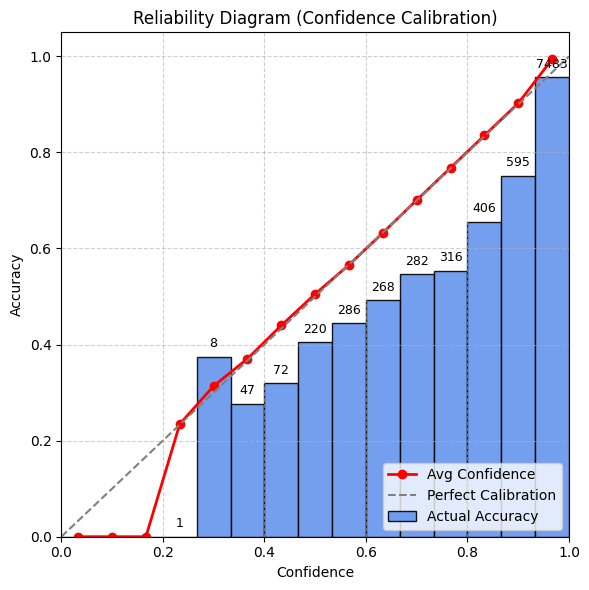

In [9]:
ece_score = compute_ece(probs, true_labels)
print(f"ECE: {ece_score:.4f}")

plot_reliability_diagram(probs, true_labels, n_bins=15)

In [10]:
def compute_multiclass_ece(probs, labels, n_bins=15):
    """
    Multiclass Expected Calibration Error (ECE).
    probs: ndarray (N, C) of softmax probabilities.
    labels: ndarray (N,) of true class indices.
    """
    n_samples, n_classes = probs.shape

    confidences = probs.flatten()
    correct = np.zeros_like(confidences)

    # One-hot encode labels
    one_hot = np.zeros_like(probs)
    one_hot[np.arange(n_samples), labels] = 1
    correct = one_hot.flatten()

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    ece = 0.0

    for i in range(n_bins):
        bin_lower = bin_boundaries[i]
        bin_upper = bin_boundaries[i + 1]
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        prop_in_bin = np.mean(in_bin)

        if np.any(in_bin):
            acc_in_bin = np.mean(correct[in_bin])
            avg_conf_in_bin = np.mean(confidences[in_bin])
            ece += np.abs(avg_conf_in_bin - acc_in_bin) * prop_in_bin

    return ece

In [11]:
def plot_multiclass_reliability(probs, labels, n_bins=15):
    """
    Plot a multiclass reliability diagram using all class confidences.
    """
    n_samples, n_classes = probs.shape
    confidences = probs.flatten()

    one_hot = np.zeros_like(probs)
    one_hot[np.arange(n_samples), labels] = 1
    correctness = one_hot.flatten()

    bin_boundaries = np.linspace(0.0, 1.0, n_bins + 1)
    bin_lowers = bin_boundaries[:-1]
    bin_uppers = bin_boundaries[1:]
    bin_centers = (bin_lowers + bin_uppers) / 2

    bin_accs = []
    bin_confs = []
    bin_counts = []

    for bin_lower, bin_upper in zip(bin_lowers, bin_uppers):
        in_bin = (confidences > bin_lower) & (confidences <= bin_upper)
        count_in_bin = np.sum(in_bin)
        bin_counts.append(count_in_bin)

        if count_in_bin > 0:
            bin_accs.append(np.mean(correctness[in_bin]))
            bin_confs.append(np.mean(confidences[in_bin]))
        else:
            bin_accs.append(0.0)
            bin_confs.append(0.0)

    # Plot
    plt.figure(figsize=(6, 6))
    plt.bar(bin_centers, bin_accs, width=1/n_bins, color='skyblue', edgecolor='black', label='Actual Accuracy')
    plt.plot(bin_centers, bin_confs, 'o-', color='red', label='Avg Confidence', linewidth=2)
    plt.plot([0, 1], [0, 1], '--', color='gray', label='Perfect Calibration')

    for i in range(n_bins):
        if bin_counts[i] > 0:
            plt.text(bin_centers[i], bin_accs[i] + 0.02, str(bin_counts[i]), ha='center', fontsize=8)

    plt.xlabel('Confidence')
    plt.ylabel('Accuracy')
    plt.title('Multiclass Reliability Diagram (All Class Predictions)')
    plt.xlim(0, 1)
    plt.ylim(0, 1.05)
    plt.grid(True, linestyle='--', alpha=0.6)
    plt.legend()
    plt.tight_layout()
    plt.show()

Multiclass ECE: 0.0136


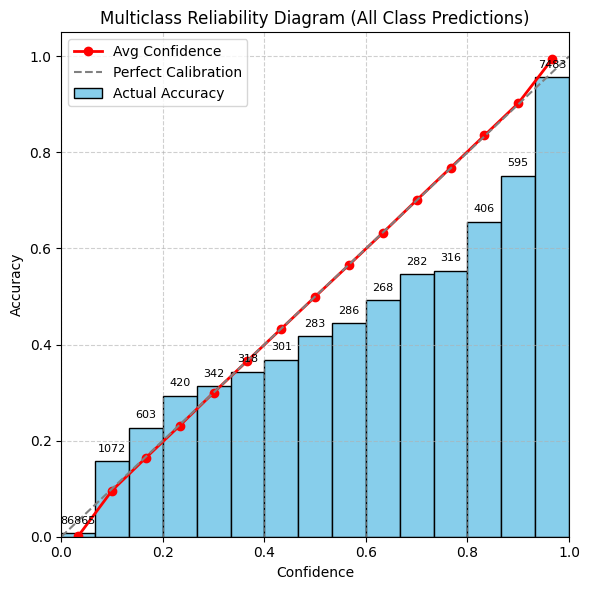

In [12]:
ece_mc = compute_multiclass_ece(probs, true_labels, n_bins=15)
print(f"Multiclass ECE: {ece_mc:.4f}")

plot_multiclass_reliability(probs, true_labels, n_bins=15)